# Eigenschaften von LTI Filtern im Frequenzbereich

Definiere zeitdiskretes System durch Zähler- und Nennerkoeffizienten (Polynomform)
 und plotte
 
 - Pol-Nullstellenplan
 - Amplituden- und Phasengang
 - 3D-Übertragungsfunktion |H(z)| und |H(e^ĵw)|
 
 Dieses Notebook ist eher ein Steinbruch, aus dem nach und nach alles zu pyFDA exportiert wurde ... nutzen Sie lieber direkt pyFDA.

============ Filter Characteristics ================

  Test Case  |  f (Hz)    |   |H(f)|   | |H(f)| (dB)
----------------------------------------------------
0            |      0.000 |   1.000000 |    0.0000
F_sig        |      0.120 |   0.677778 |   -3.3783
0.5          |      0.500 |   0.000000 | -324.2604
Maximum      |      0.000 |   1.000000 |    0.0000 
Minimum      |      0.500 |   0.000767 |  -62.3042 




C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:267: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


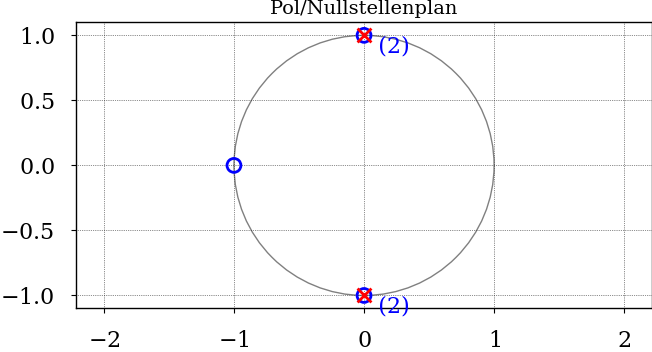

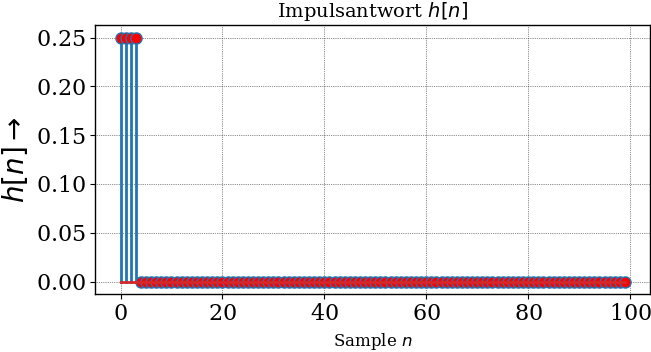

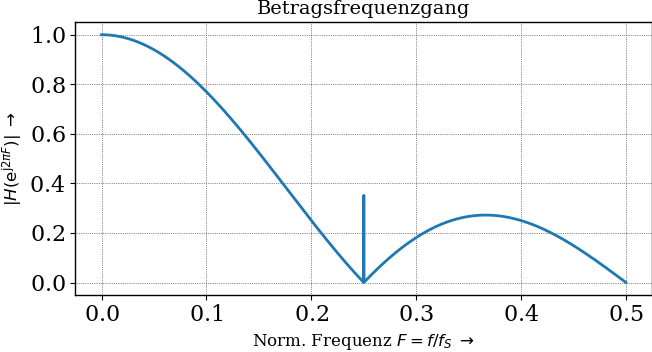

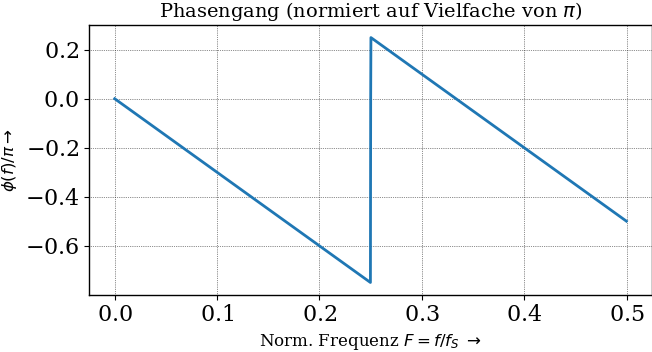

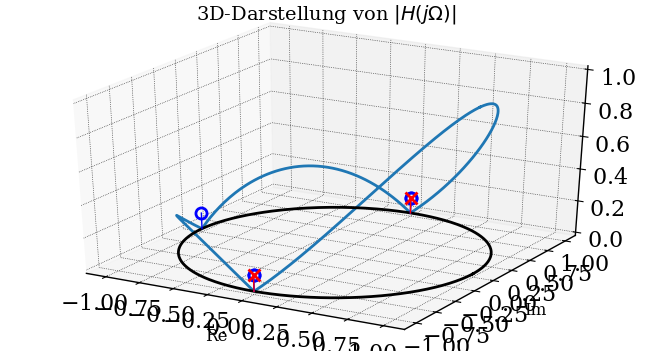

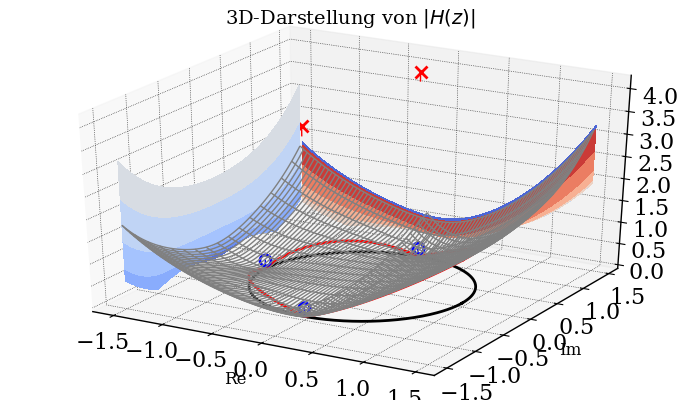

In [1]:
import numpy as np
from numpy import (pi, log10, exp, sqrt, sin, cos, tan, angle, arange, 
                   linspace, array, zeros, ones)
import scipy.signal as sig

import matplotlib.pyplot as plt
from matplotlib.pyplot import (figure, plot, stem, grid, xlabel, ylabel,
    subplot, title, clf, xlim, ylim)
%matplotlib inline

import sys
sys.path.append("..") 
import dsp_fpga_lib as dsp

from mpl_toolkits.mplot3d import Axes3D # needed for 'projection3d'
from matplotlib import cm # Colormap

font = {'family' : 'serif', 'weight' : 'normal', 'size'   : 16}
font_math = {'size'   : 16}
plt.rc('font', **font)
#plt.rc('mathtext.fontset','stix') # set Font for plots
plt.rc('lines', linewidth=2, color='r') 
#rcParams['font.size'] = 12.0
#rcParams['mathtext.default'] = 'regular'
#rcParams['mathtext.fontset'] = 'stixsans'

DEF_PRINT = False    # Print plots to files?
# Path and base-name of plot-Files:
PRINT_PATH = ('D:/Daten/HM/dsvFPGA/Uebungen/HM/plots/MA_Filter_') 
PRINT_TYPE = '.png' # Graphic-format .pdf, .png, .jpg, ..
#-----------------------------------------------------------------------------
# Select plot options
#-----------------------------------------------------------------------------
SHOW_POLE_ZERO =    1     # Pole-zero-plot
SHOW_LIN_H_f =      1     # Linear plot of H(f)
SHOW_LOG_H_f =      0     # Log. plot of H(f)
SHOW_PHASE =        1     # Phase response
SHOW_GRPDELAY =     0     # Group delay
SHOW_IMPZ =         1     # Impulse response
SHOW_3D_LIN_H_F =   1
SHOW_3D_LOG_H_F =   0     # 3D Line Plot
SHOW_3D_H_z =       1     # surface plot (slow!)

PLT_AUTOx = False # Automatic x-Axis scaling - zooming in does not work properly
PLT_PHASE_WRAP = False # Wrap phase to +/- pi

#-----------------------------------------------------------------------------
# Frequency axis settings and Filter specs
#-----------------------------------------------------------------------------
DEF_F_RANGE = '1/2' # select how to display the frequency axis:
#                       '1/2'   normalized frequency F = 0 ... 0.5 (f_S/2)
#                       '1'     normalized frequency F = 0 ... 1 (f_S)
#                       'f_S/2' absolute frequency f = 0 ... f_S/2
#                       'f_S'   absolute frequency f = 0 ... f_S
 
N_FFT = 2048 # FFT length for freqz and grpdelay
f_S = 100.0 # Samplingfrequenz 
f_S2 = f_S/2. #Samplingfrequenz 
f_sig = 12.0 # Testsignalfrequenz
#
FILT_TYPE = 'IIR'    # 'FIR' or 'IIR' transfer function

#-----------------------------------------------------------------------------
# Define 3D-Plotting Options
#-----------------------------------------------------------------------------
PLT_min_dB = -80

OPT_3D_POLAR_SPEC = False # Plot circular range in 3D-Plot
OPT_3D_FORCE_ZMAX = True # Enforce absolute limit for 3D-Plot
OPT_3D_PLOT_TYPE = 'MESH' # options: 'MESH', 'SURF', 'TRI_SURF' 'CONT3D'
OPT_3D_CONTOUR = True # plot 2D Contour "wallpapers"
OPT_3D_MSTRIDE = 1 # Schrittweite für MESH und CONT3D
#OPT_3D_PLOT_MESH = False  # 3D plot of |H(z)| as mesh instead of surface
OPT_3D_ALPHA = 1 # Transparency for surface plot
#
steps = 80               # number of steps for x, y, r, phi
rmin = 0;    rmax = 1.0  # polar range definition
#
xmin = -1.5; xmax = 1.5  # cartesian range definition
ymin = -1.5; ymax = 1.5
#
zmin =  -1.0; zmax = 4.0 # zmax only used when OPT_3D_FORCE_ZMAX = True
zmax_rel = 5 # Max. displayed z - value relative to max|H(f)|
#
plevel_rel = 1.05 # height of plotted pole position relative to zmax
zlevel_rel = 0.05 # height of plotted zero position relative to zmax
PN_SIZE = 8 # size of P/N symbols
###########################################################################
################ NO USER INPUTS AFTER THIS LINE ###########################
###########################################################################
#==========================================================================
# relative Grenzfrequenzen auf Abtastfrequenz bezogen
#==========================================================================

F_sig = f_sig / f_S

#==========================================================================
# Frequenzachse skalieren und Label wählen
#==========================================================================
whole = False
if DEF_F_RANGE == 'f_S/2':
    f_range = (0, f_S/2) # define tuple for x-axis
elif DEF_F_RANGE == 'f_S':
    f_range = (0, f_S)
    whole = True
elif DEF_F_RANGE == '1/2':
    f_S = 1.
    f_range = (0, 0.5)
elif DEF_F_RANGE == '1':
    f_S = 1.
    f_range = (0, 1)
    whole = True
else: sys.exit("Ungültiges Format für DEF_F_RANGE!")  
T_S = 1/f_S
#
# Define x-axis labels depending on the sampling frequency
if f_S == 1:
    my_x_axis_f = r'Norm. Frequenz $F = f / f_S \; \rightarrow$'
    my_x_axis_t = r'Sample $n$'
    f_scale = 1.; f_unit = ''; t_unit = ''; N_F = 2
else:    
    if (f_S <= 2.) and (f_S > 2.e-3):
        f_scale = 1.e3; f_unit = 'mHz'; t_unit = 's'
    if (f_S <= 2.e3) and (f_S > 2.):
        f_scale = 1.; f_unit = 'Hz'; t_unit = 'ms'
    if (f_S <= 2.e6) and (f_S > 2.e3):
        f_scale = 1.e-3; f_unit = 'kHz'; t_unit = 'us'
    if (f_S <= 2.e9) and (f_S > 2.e6):
        f_scale = 1.e-6; f_unit = 'MHz'; t_unit = 'ns'
    if (f_S <= 2.e12) and (f_S > 2.e9):
        f_scale = 1.e-6; f_unit = 'GHz'; t_unit = 'ps'
    # calculate number of fractional places for a nice display 
    N_F = str(int(3 - np.floor(log10(f_S * f_scale))))
    N_F_str = '%.' + N_F + 'f'
    if PLT_AUTOx:
        my_x_axis_f = r'Frequenz ['+ f_unit +'] $\rightarrow$'
        my_x_axis_t = 'Zeit ['+ t_unit + '] ->'
    else:
        my_x_axis_f = r'Frequenz [Hz] $\rightarrow$'
        my_x_axis_t = 'Zeit [s] ->'    
   

##############################################################################
##############################################################################
#
# FIR-Filter
#
if FILT_TYPE == 'FIR':

    #bb = [1, 2, 3, 4, 5]
    #bb = [1, 0, 1, 0, 1, 0, 1]
    #bb = [-1/8, 0, 5/8, 1, 5/8, 0, -1/8]
    #bb = [-0.07, 0.43, -0.43, 0.07]
    #bb = [1,0,0,0,-1]
    bb = [1,0,2,0,1]
    bb = 1./16 * np.ones(16)
#    bb = [1,0,1,0]
#    bb = [1, -3, 3, -1]
    # Optional: Cascade filter twice by convolving coefficients with themselves
#    bb = np.convolve(bb,bb)
    #bb = [1,2,3,2,1]
#    bb = sig.remez(16, [0, 1/8, 1/4, 0.5],[1,0],[6,1])

    aa = zeros(len(bb)-1)
    aa = np.append(1.,aa) # create same number of poles at origin (FIR)

else: # FILT = 'IIR'
    
    bb, aa = ([1, 1],[1, -1.5, 0.9])
#    bb, aa =[1], [1,0,0.64]
#    bb, aa = [1], [1, -1]
    bb, aa = sig.ellip(4, 0.1, 40, 0.2)
    
    #bb, aa = ([1,0,0,0,-1],[-1,1])
    bb, aa = (0.25*np.convolve([1,0,2,0,1], [1,1]),[1, 0,1])


##############################################################################

[w, H] = sig.freqz(bb, aa, N_FFT, whole) # calculate H(w) along the 
                                        # upper half of unity circle
                                        # w runs from 0 ... pi, length = N_FFT
f = w / (2 * pi) * f_S                  # translate w to absolute frequencies

H_abs = abs(H)
H_max = max(H_abs); H_max_dB = 20*log10(H_max); F_max = f[np.argmax(H_abs)]

#
H_min = min(H_abs); H_min_dB = 20*log10(H_min); F_min = f[np.argmin(H_abs)]
min_dB = np.floor(max(PLT_min_dB, H_min_dB) / 10) * 10

nulls = np.roots(bb)
poles = np.roots(aa)

#################################################################
#                                                               #
#            Print Filter properties                            #
#                                                               #
#################################################################

F_test = array([0, F_sig, 0.5]) # Vektor mit Testfrequenzen
Text_test = ('0', 'F_sig', '0.5')
# Berechne Frequenzantwort bei Testfrequenzen und gebe sie aus:
[w1, H_test] = sig.freqz(bb, aa, F_test * 2.0 * pi)
f1 = w1  * f_S / (2.0 * pi)
        
print('============ Filter Characteristics ================\n')
print('  Test Case  |  f (Hz)    |   |H(f)|   | |H(f)| (dB)')
print('----------------------------------------------------')
for i in range(len(H_test)):
    print('{0:12} | {1:10.3f} | {2:10.6f} | {3:9.4f}'\
        .format(Text_test[i], f1[i], abs(H_test[i]), 20*log10(abs(H_test[i]))))
print('{0:12} | {1:10.3f} | {2:10.6f} | {3:9.4f} '\
    .format('Maximum', F_max, H_max, H_max_dB))
print('{0:12} | {1:10.3f} | {2:10.6f} | {3:9.4f} '\
    .format('Minimum', F_min, H_min, H_min_dB))
print('\n')


#################################################################
#                                                               #
#            Plot the Results                                   #
#                                                               #
#################################################################

plt.close('all') # close all "old" figures
#mlab.close(all=True) # alle Mayavi (3D) Fenster schließen

#=========================================
## Pol/Nullstellenplan
#=========================================
if SHOW_POLE_ZERO == True:
    plt.figure(1)
    [z, p, k] = dsp.zplane(bb, aa)
    plt.title('Pol/Nullstellenplan')
    plt.grid('on')
#    plt.text(-0.95,0.0 ,'(2)')
    plt.axis([-1.1, 1.1, -1.1, 1.1])
    plt.tight_layout() 
    if DEF_PRINT == True:
        plt.savefig((PRINT_PATH +'PZ' + PRINT_TYPE))

#=========================================
## Impulsantwort
#=========================================

if SHOW_IMPZ == True:
    plt.figure(2)
    [h, td]=dsp.impz(bb, aa, f_S)  #Impulsantwort / Koeffizienten
    [ml, sl, bl] = plt.stem(td, h) 
    plt.grid('on')
    plt.setp(ml, 'markerfacecolor', 'r', 'markersize', 8)
    plt.xlabel(my_x_axis_t)
    plt.ylabel(r'$h[n] \rightarrow $', fontsize = 20)
    plt.title(r'Impulsantwort $h[n]$')
    plt.tight_layout()
    if PLT_AUTOx: dsp.format_ticks('x', f_scale*1000, "%.3g")
    if DEF_PRINT == True:
        plt.savefig((PRINT_PATH + 'impz' + PRINT_TYPE))

#=========================================
## Linear frequency plot
#=========================================
if SHOW_LIN_H_f == True:
    plt.figure(3)
    ax3 = plt.subplot(111)
    ax3.plot(f, H_abs); plt.grid('on')
    #plt.axis(f_range + (0., 1.2)
    plt.title(r'Betragsfrequenzgang')
    plt.xlabel(my_x_axis_f)
    plt.ylabel(r'$|H(\mathrm{e}^{\mathrm{j} 2 \pi F})|\; \rightarrow $')
#    ax3.annotate("einfache",
#            xy=(0.36, 0.05), xycoords='data',
#            xytext=(0.28, 1.5), textcoords='data',
#            size=20, va="center", ha="center",
#            arrowprops=dict(arrowstyle="simple",
#                            connectionstyle="arc3,rad=-0.2"),
#                            )
#    ax3.annotate("doppelte\n Nullstelle",
#            xy=(0.5, 0.05), xycoords='data',
#            xytext=(0.42, 1.5), textcoords='data',
#            size=20, va="center", ha="center",
#            arrowprops=dict(arrowstyle="simple",
#                            connectionstyle="arc3,rad=-0.2"),
#                            )
    if PLT_AUTOx: dsp.format_ticks('x', f_scale, N_F_str)  
    plt.tight_layout() # pad=1.2, h_pad=None, w_pad=None
    if DEF_PRINT == True:
        plt.savefig(PRINT_PATH + 'lin' + PRINT_TYPE)
        
#=========================================
## Log frequency plot
#=========================================
if SHOW_LOG_H_f == True:
    plt.figure(4)
    plt.plot(f, 20 * log10(abs(H))); plt.grid('on')
    #plt.axis(f_range + (0., 1.2)
    plt.title(r'Log. Betragsfrequenzgang in dB')
    plt.xlabel(my_x_axis_f)
    plt.ylabel(r'$20\, \log \,|H(\mathrm{e}^{\mathrm{j} 2 \pi F})|\;\rightarrow $')
    plt.ylim(PLT_min_dB, 20*log10(H_max))
    if PLT_AUTOx: dsp.format_ticks('x', f_scale, N_F_str)
    plt.tight_layout()
    if DEF_PRINT == True:
        plt.savefig(PRINT_PATH + 'log' + PRINT_TYPE)

#=========================================
## Phasengang 
#=========================================#
if SHOW_PHASE == True:
    fig6 = plt.figure(6)
    ax6 = fig6.add_subplot(111)
    if PLT_PHASE_WRAP == True:
        ax6.plot(f, np.angle(H) / pi)
    else:
        ax6.plot(f, np.unwrap(np.angle(H))/pi)
    ax6.grid('on')
    # Ohne unwrap wird Phase auf +/- pi umgebrochen
    ax6.set_title(r'Phasengang (normiert auf Vielfache von $\pi$)')
    ax6.set_xlabel(my_x_axis_f)
    ax6.set_ylabel(r'$\phi(f) / \pi \rightarrow $')
    if PLT_AUTOx: dsp.format_ticks('x',f_scale, N_F_str)  
    plt.tight_layout() 
    if DEF_PRINT == True:
        plt.savefig(PRINT_PATH +'phase'+ PRINT_TYPE)

#=========================================
## Groupdelay
#=========================================
if SHOW_GRPDELAY == True:
    fig7 = plt.figure(7)
    ax7 = fig7.add_subplot(111)
    [tau_g, w] = dsp.grpdelay(bb,aa,N_FFT, whole, f_S)
    ax7.plot(w, tau_g); plt.grid('on')
    ax7.axis(f_range + (max(min(tau_g)-0.5,0), max(tau_g) + 0.5))
    ax7.set_title(r'Group Delay $ \tau_g$') # (r: raw string)
    ax7.set_xlabel(my_x_axis_f)
    ax7.set_ylabel(r'$ \tau_g(f)/T_S$')
    if PLT_AUTOx: dsp.format_ticks('x',f_scale, N_F_str)
    plt.tight_layout()
    if DEF_PRINT == True:
        plt.savefig(PRINT_PATH +'grpdelay' + PRINT_TYPE)

#===============================================================
## 3D-Plots
#===============================================================
if OPT_3D_FORCE_ZMAX == True:
    thresh = zmax
else:
    thresh = zmax_rel * H_max # calculate display thresh. from max. of H(f)

plevel = plevel_rel * thresh # height of displayed pole position
zlevel = zlevel_rel * thresh # height of displayed zero position

# Calculate limits etc. for 3D-Plots
dr = rmax / steps * 2 
dphi = pi / steps # grid size for polar range
dx = (xmax - xmin) / steps  
dy = (ymax - ymin) / steps # grid size cartesian range
if OPT_3D_POLAR_SPEC == True: # polar grid
    [r, phi] = np.meshgrid(np.arange(rmin, rmax, dr), np.arange(0,2*pi,dphi)) 
#    [x, y] = np.pol2cart(phi,r) # 
    x = r * cos(phi); y = r * sin(phi)
else: # cartesian grid
    [x, y] = np.meshgrid(np.arange(xmin,xmax,dx), np.arange(ymin,ymax,dy)) 

z = x + 1j*y # create coordinate grid for complex plane



phi_EK = np.linspace(0,2*pi,400) # 400 points from 0 ... 2 pi
xy_EK = np.exp(1j * phi_EK) # x,y coordinates of unity circle
H_EK = dsp.H_mag(bb, aa, xy_EK, thresh) #|H(jw)| along the unity circle
Hmag = dsp.H_mag(bb, aa, z,thresh) #|H(z)| 

#===============================================================
## 3D-Plot of |H(f)| - linear scale
#===============================================================
if SHOW_3D_LIN_H_F == True:
    fig = plt.figure(10)
    ax10 = fig.gca(projection='3d')
    #plot ||H(f)| along unit circle as line
    plt.plot(xy_EK.real, xy_EK.imag, H_EK, linewidth=2) 
    # Plot unit circle:
    plt.plot(xy_EK.real, xy_EK.imag, zeros(len(xy_EK)), 
             linewidth=2, color = 'k')
    ax10.plot(nulls.real, nulls.imag, np.ones(len(nulls)) * H_max * 0.1 , 
        'o', markersize = PN_SIZE, markeredgecolor='blue', markeredgewidth=2.0,
        markerfacecolor = 'none') # plot nulls
        
    for k in range(len(nulls)): # plot "stems"
        ax10.plot([nulls[k].real, nulls[k].real],
                    [nulls[k].imag, nulls[k].imag],
                    [0, H_max * 0.1], linewidth=1, color='b')
   
    # Plot the poles at |H(z_p)| = plevel with "stems":
    ax10.plot(np.real(poles), np.imag(poles), H_max * 0.1,
      'x', markersize = PN_SIZE, markeredgewidth=2.0, markeredgecolor='red') 
    for k in range(len(poles)): # plot "stems"
        ax10.plot([poles[k].real, poles[k].real],
                    [poles[k].imag, poles[k].imag],
                    [0, H_max * 0.1], linewidth=1, color='r')
    plt.title(r'3D-Darstellung von $|H(j\Omega)|$')
    plt.xlabel('Re')
    plt.ylabel('Im')
    plt.tight_layout() # pad=1.2, h_pad=None, w_pad=None

    if DEF_PRINT: plt.savefig(PRINT_PATH + '3D_lin' + PRINT_TYPE)

#===============================================================
## 3D-Plot of log |H(f)|
#===============================================================
if SHOW_3D_LOG_H_F == True:
    fig = plt.figure(11)
    ax = fig.gca(projection='3d')
  #  ax = fig.add_subplot(111, projection='3d')
    # Plot unit circle:
    ax.plot(xy_EK.real, xy_EK.imag, 
            np.maximum(20*log10(H_EK), min_dB), linewidth=2)
    # Plot thin vertical lines:
    NL = 2 # plot line every NL points on the EK
    for k in range(len(xy_EK[::NL])):
        ax.plot([xy_EK.real[::NL][k], xy_EK.real[::NL][k]],
                [xy_EK.imag[::NL][k], xy_EK.imag[::NL][k]],
                [np.zeros(len(xy_EK[::NL]))[k], 
                                 np.maximum(20*log10(H_EK[::NL][k]), min_dB)],
                 linewidth=1, color=(0.5, 0.5, 0.5))
    # Plot unit circle:
    ax.plot(xy_EK.real, xy_EK.imag, zeros(len(xy_EK)),
            linewidth=2, color='k')

    ax.set_title(r'3D-Darstellung von $20 \log |H(e^{j\Omega})|$ in dB')
    ax.set_xlabel('Re')
    ax.set_ylabel('Im')

    if DEF_PRINT == True:
        plt.savefig(PRINT_PATH + '3D_log' + PRINT_TYPE)
#===============================================================
## 3D-Surface Plot
#===============================================================    
if SHOW_3D_H_z == True:
#    fig_mlab = mlab.figure(fgcolor=(0., 0., 0.), bgcolor=(1, 1, 1))
    fig12 = plt.figure(12)
#    ax12 = fig12.add_subplot(111, projection='3d')
    ax12 = Axes3D(fig12)
#    ax12.set_zlim(0,2)

    if OPT_3D_PLOT_TYPE == 'MESH':
        #plot 3D-mesh of |H(z)| clipped at |H(z)| = thresh        
        g=ax12.plot_wireframe(x, y, dsp.H_mag(bb, aa, z,thresh), rstride=5,
                              cstride=OPT_3D_MSTRIDE, linewidth = 1, color = 'gray') 
#        [xplane, yplane, zplane] = np.ogrid[-5:5:100 , -5:5:100 , -5:5:100]
    elif OPT_3D_PLOT_TYPE == 'SURF':
        #plot 3D-surface of |H(z)|; clipped at |H(z)| = thresh
        g=ax12.plot_surface(x,y,dsp.H_mag(bb,aa,z,thresh), 
                alpha = OPT_3D_ALPHA, rstride=1, cstride=1, cmap = cm.prism,
                linewidth=0, antialiased=False, edgecolor = 'grey', shade = True)
 #       ax12.contourf(x, y, dsp.H_mag(bb,aa,z,thresh), zdir='z', offset=-1, cmap=cm.hot)
                # Colormaps: 'hsv', 'jet', 'bone', 'prism' 'gray' 'colorcube'
#       ax.setp(g,'EdgeColor', 'r')#(.4, .4, .4)) # medium gray color for mesh
    else: # Contour plot
        ax12.contourf3D(x,y,dsp.H_mag(bb,aa,z,thresh),
                        rstride=OPT_3D_MSTRIDE, cstride=OPT_3D_MSTRIDE)
    if OPT_3D_CONTOUR:
#        cset = ax12.contourf(x, y, Hmag, zdir='z', offset=zmin, cmap=cm.coolwarm)
        cset = ax12.contourf(x, y, Hmag, zdir='x', offset=xmin, 
                             vmin = zmin, vmax = zmax, cmap=cm.coolwarm)
        cset = ax12.contourf(x, y, Hmag, zdir='y', offset=ymax, cmap=cm.coolwarm)

    # Plot unit circle:
    ax12.plot(xy_EK.real, xy_EK.imag, zeros(len(xy_EK)), 
              linewidth=2, color ='k')
    #plot ||H(f)| along unit circle as line
    ax12.plot(xy_EK.real, xy_EK.imag, H_EK, linewidth=2, color = 'r') 
    # Plot the zeros at (x,y,0) with "stems":
    ax12.plot(nulls.real, nulls.imag, np.ones(len(nulls)) * zlevel, 
        'o', markersize = PN_SIZE, markeredgecolor='blue',markeredgewidth=2.0,
        markerfacecolor='none') 
    for k in range(len(nulls)): # plot "stems"
        ax12.plot([nulls[k].real, nulls[k].real],
                    [nulls[k].imag, nulls[k].imag],
                    [0, zlevel], linewidth=1, color='b')
    # Plot the poles with "stems" from thresh to plevel
    ax12.plot(poles.real, poles.imag, plevel,
      'x', markersize = PN_SIZE, markeredgewidth=2.0, markeredgecolor='red') 
    for k in range(len(poles)): # plot "stems"
        ax12.plot([poles[k].real, poles[k].real],
                    [poles[k].imag, poles[k].imag],
                    [thresh, plevel], linewidth=1, color='r')
                
    ax12.set_title( r'3D-Darstellung von $|H(z)|$')
    ax12.set_xlabel('Re')
    ax12.set_ylabel('Im')

#    fig12.colorbar()
    if DEF_PRINT == True:
        fig12.savefig(PRINT_PATH + '3D_surf' + PRINT_TYPE)
      
plt.show()


### Aufgaben
- Stellen Sie die Impulsantwort für verschiedene Positionen von Polen und Nullstellen dar

***
### Copyright

(c) 2016 - 2021 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp_fpga "Digital Signal Processing"

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing - Vorlesungsunterlagen mit Simulationsbeispielen, 2020*.